# Units

Questions about the parameters:  
Protons Flux ? How is it defined (protons/sec) ?  
Check formula for D ? Right stdev ?  
Right noise ? Not sure about this it.  


# TODO
Normalizer 
calculer coarse D (sur les centres de gravité)
creer le cnn, commencer à fit

# Parameters


Positions in nm  
1 pixel is 100nm  
Image size: Nx * Ny * Nt  
Nx = Ny = 100 pixels  
Nt: number of frames 10   
Interframe positions: 10  
The mollecule always starts in the center of the first frame.  
delta_t: Time between two frames: 10 ms  
Generate images for a chosen D in [10^-1, 10] (micro_meter)^2/second  
Microscope FWHM (Full width half maximum): 100nm (later push up to 250nm)  
Flux: 10 photons/ms  
Amplitude of diraqs: Flux * delta_t /Interframe positions  
PSF (Point Spread function): start with Gaussian, then use specified one 


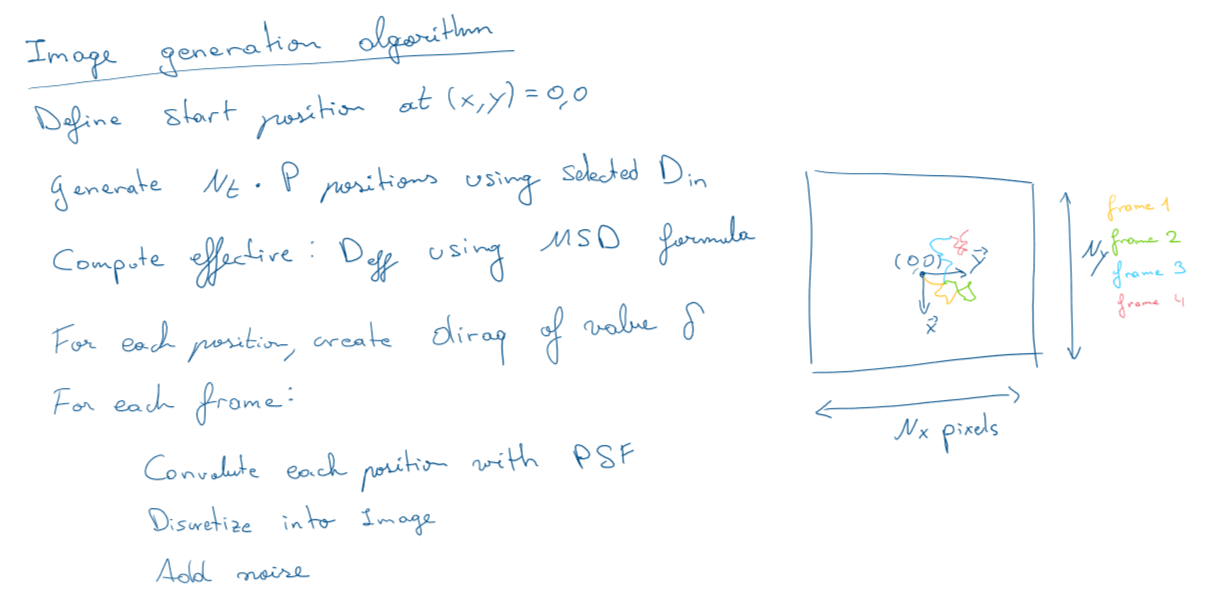

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from skimage.io import imsave
import time
import numpy as np
from skimage.measure import block_reduce
from skimage.util import random_noise
from sklearn.linear_model import LinearRegression


In [ ]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 8    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
D = 1000.0        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe

# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value

In [3]:
from helpers import *

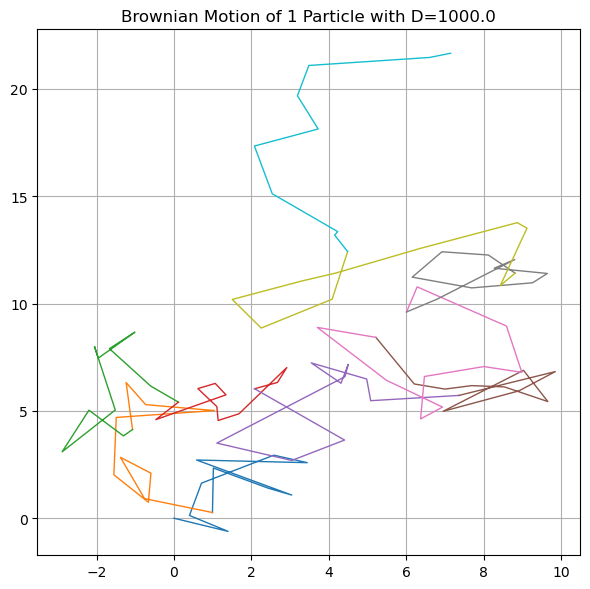

In [4]:
trajectory = brownian_motion(1, nframes, nposframe, D, dt,True)[0,:,:]
plot1ParticleTrajectory(trajectory, nframes, D)

Estimated Diffusion Coefficient: 1003.0464190353654


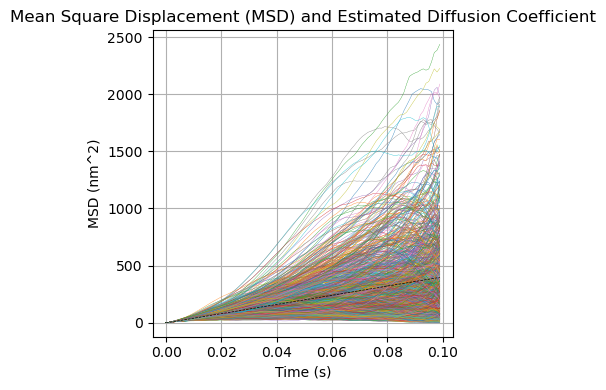

In [5]:
trajectories = brownian_motion(nparticles, nframes, nposframe, D, dt,True)
msds =  mean_square_displacements(trajectories) 
mean_estimated_D = computeAndPlotMeanMSD(msds,nparticles,nframes,nposframe,dt)


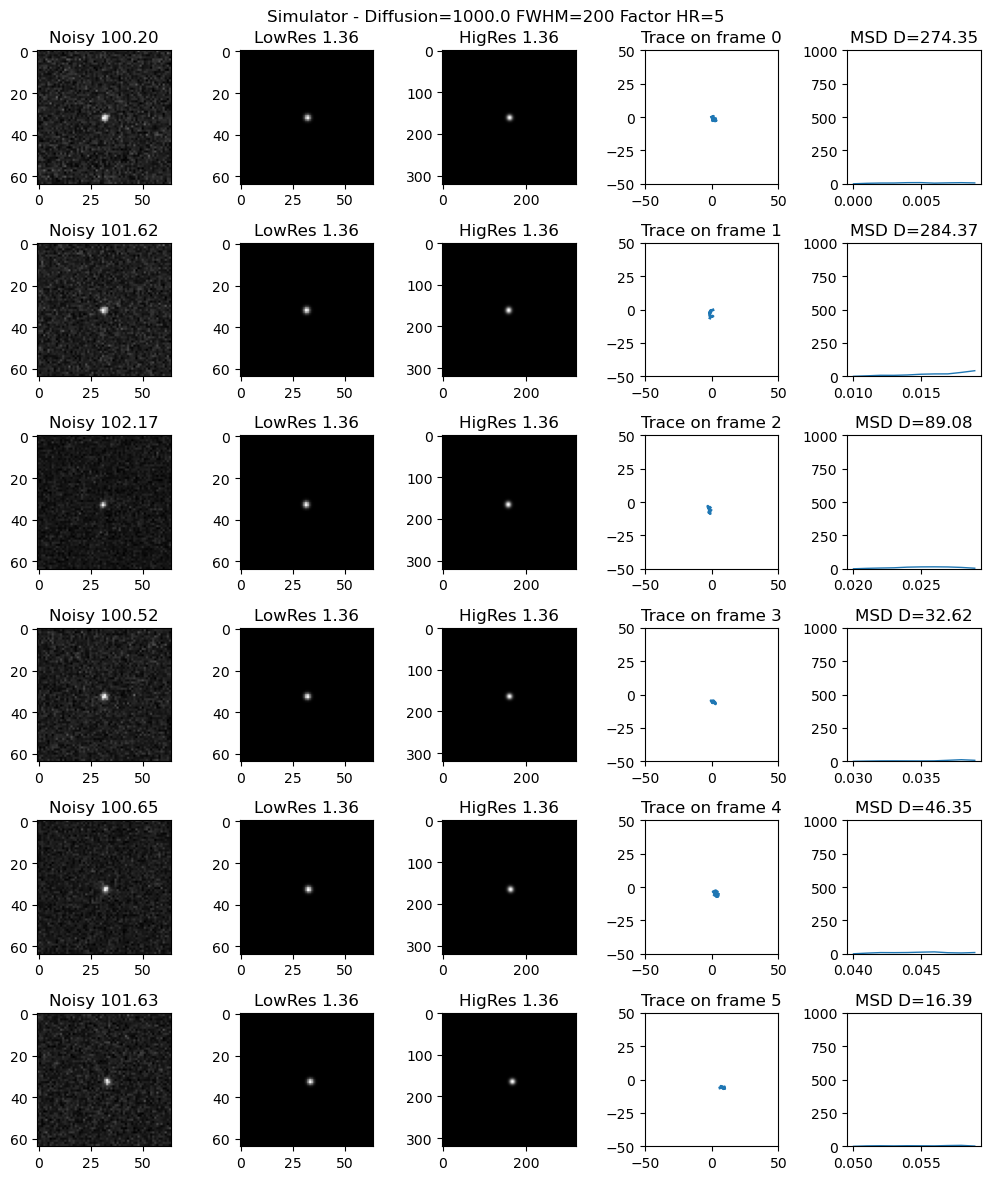

In [6]:
generateImagesAndGraphs(trajectory, D, nframes, npixel, factor_hr, nposframe, dt, fwhm_psf, pixelsize, flux, background, poisson_noise, gaussian_noise)

Estimated D: 450.2966907361721
Estimated D: 251.62828618322638
Estimated D: 6637.302567303868
Estimated D: 19204.27269448141
Estimated D: 27659.776455841224
Estimated D: 52732.719672023384


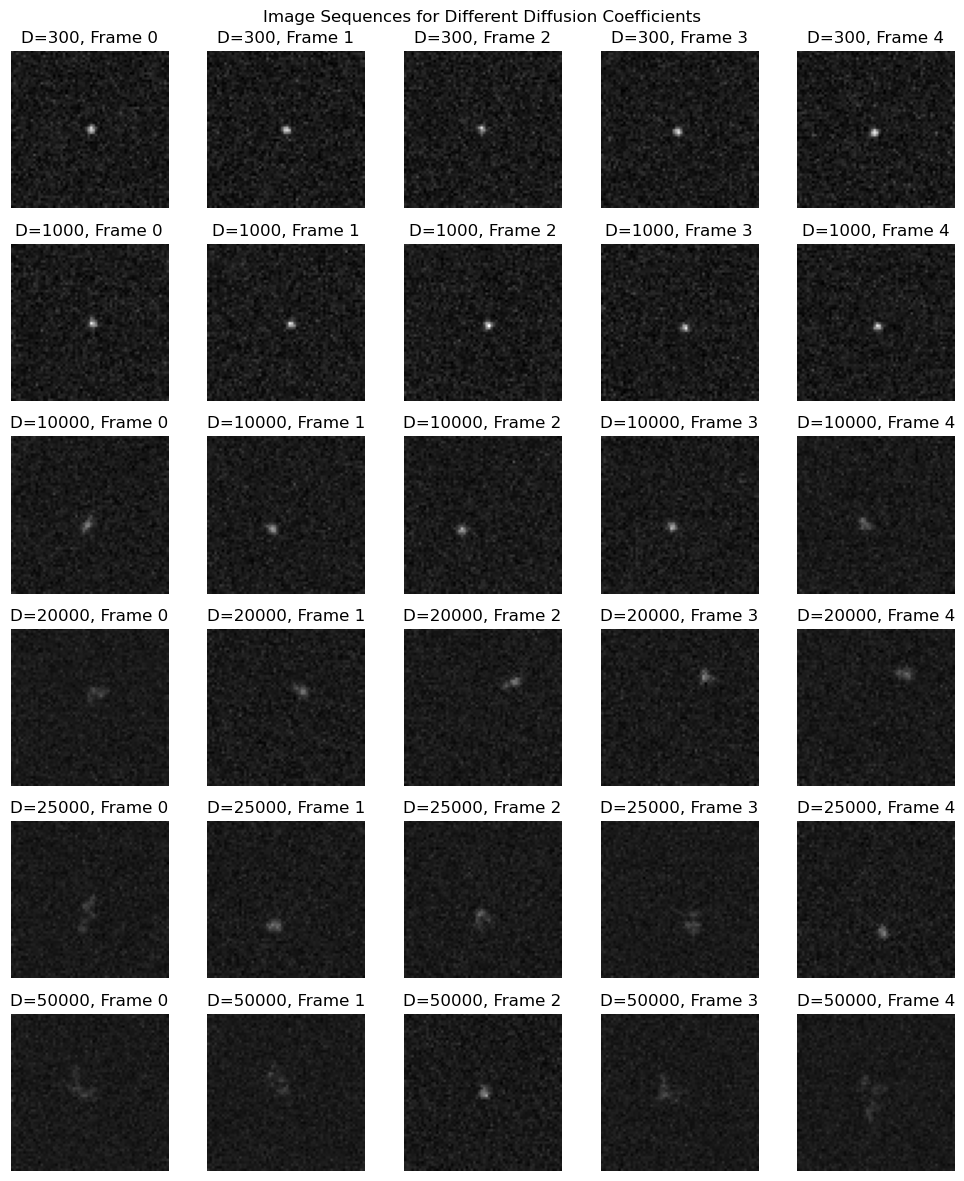

In [7]:
generateAndPlotMultipleDiffusionSequences([300,1000,10000,20000,25000,50000], nframes, npixel, factor_hr, nposframe, dt, fwhm_psf, pixelsize, flux, background, poisson_noise, gaussian_noise)

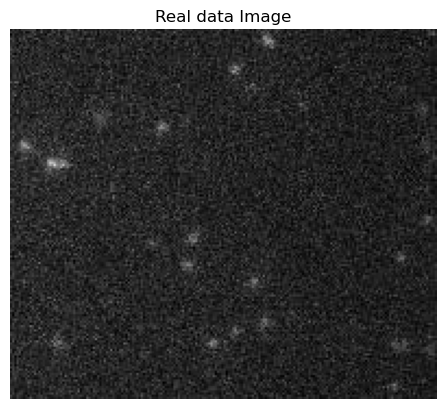

Minimum intensity: 0.00
Maximum intensity: 221.00
Mean intensity: 37.53


In [91]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

# Load the image and convert to grayscale
grayscale_image = io.imread('./real-data/snapshot.png')

# Display the image
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')
plt.title("Real data Image")
plt.show()

# Calculate and print intensity statistics
min_intensity = np.min(grayscale_image)
max_intensity = np.max(grayscale_image)
mean_intensity = np.mean(grayscale_image)

print(f"Minimum intensity: {min_intensity:.2f}")
print(f"Maximum intensity: {max_intensity:.2f}")
print(f"Mean intensity: {mean_intensity:.2f}")

In [17]:
particlesToGen = 16
DGen = 10000
images, estimatedDs = generateImagesAndEstimateD(
    particlesToGen, 1, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,
    flux, background, poisson_noise, gaussian_noise)





12.0
469.0
100.877197265625
0.0
603.0
101.5419921875
0.0
663.0
100.501708984375
0.0
503.0
101.15625
0.0
527.0
100.20068359375
10.0
459.0
100.20166015625
0.0
599.0
101.27587890625
0.0
627.0
100.039794921875
9.0
373.0
101.59765625
0.0
501.0
100.077880859375
0.0
735.0
101.97998046875
10.0
551.0
100.496337890625
0.0
506.0
100.168701171875
0.0
727.0
101.5087890625
10.0
442.0
100.791015625
0.0
665.0
102.141357421875


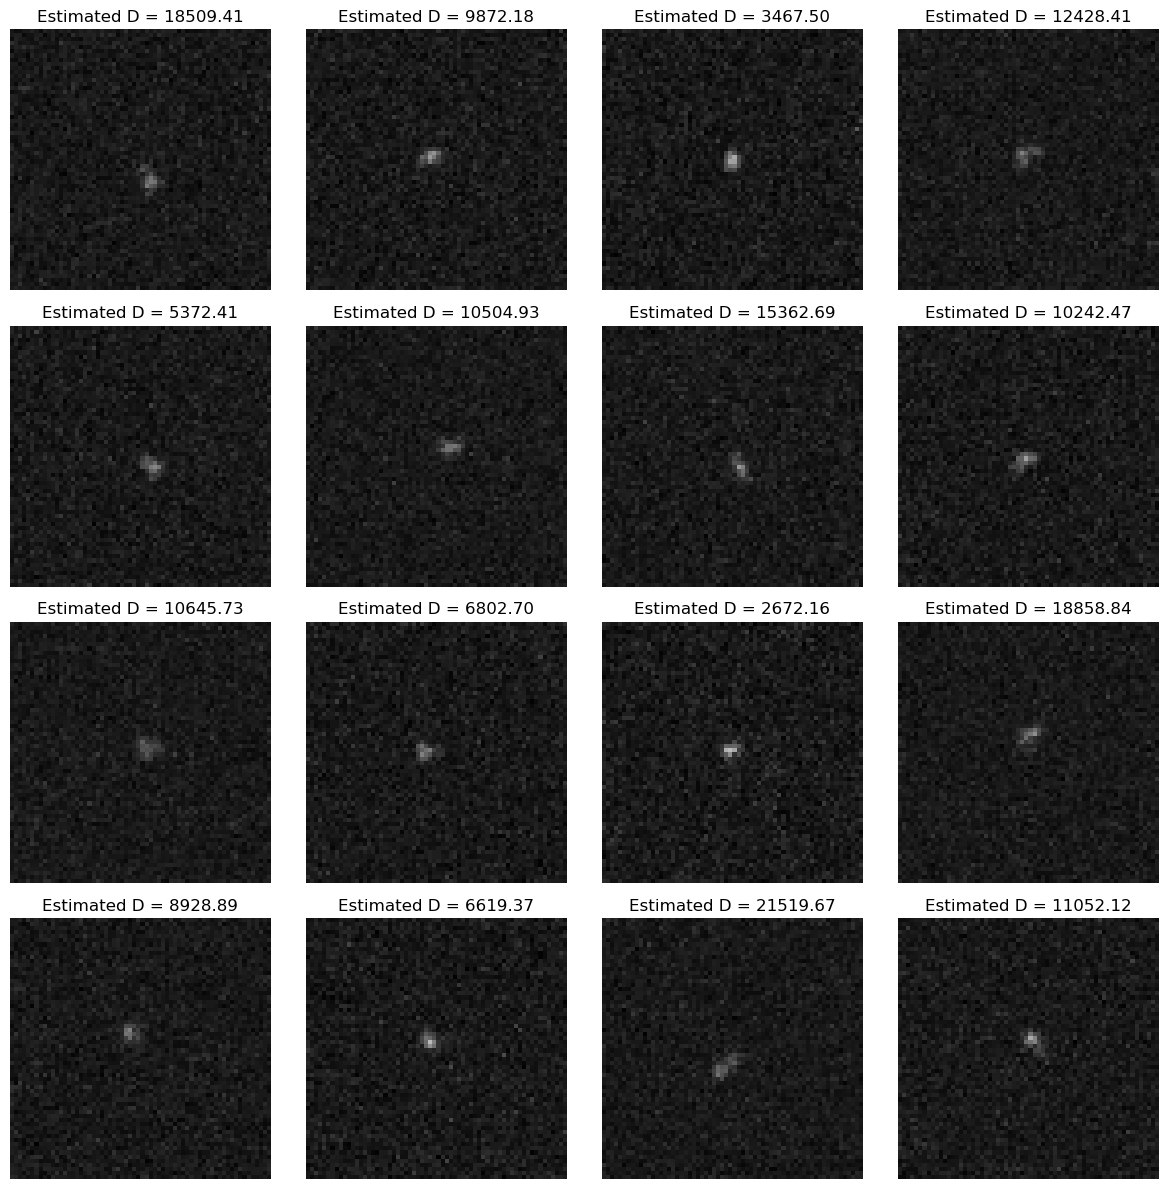

In [19]:
import matplotlib.pyplot as plt

def plot_first_frames(images, particlesToGen, nframes):
    """
    Plots the first frame for each particle in the simulation.

    Args:
        images (np.ndarray): The simulated images, shape (particlesToGen, nframes, npixel, npixel).
        particlesToGen (int): Number of particles generated.
        nframes (int): Number of frames per particle simulation.

    Returns:
        None
    """
    # Set up the grid dimensions for plotting
    grid_size = int(np.ceil(np.sqrt(particlesToGen)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(particlesToGen ):
        print(np.min(images[i,0]))
        print(np.max(images[i,0]))
        print(np.mean(images[i,0]))

        ax = axes[i]
        ax.imshow(images[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1000)
        ax.set_title(f"Estimated D = {estimatedDs[i]:.2f}")
        ax.axis('off')  # Turn off axis for cleaner visualization
    
    # Hide unused subplots
    for j in range(particlesToGen, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the first frames
plot_first_frames(images, particlesToGen, nframes)